In [1]:
# DEPENDENCIES
%matplotlib inline
import numpy as np
from environment import ENVIRONMENT
import scipy.ndimage
from auv import AUV
from Astar import Node
from visualization import VISUALIZATION
from mission import MISSION
from unittests import *
from numpy.testing import assert_allclose
from nose.tools import assert_equal
from utils import InspectReefData2D, InspectReefData3D, InspectReefData2DComplete
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
size = 9

# set size of the plot
plt.rcParams['figure.figsize'] = [size, size]

# Energy Efficient Path Planning in Uncertain Environments

# 1.0 Introduction
### 1.1 Motivation 
Science gain on exploration missions is often limited by factors related to the vehicle's endurance. In particular, energy consumption and battery capacity often limit the length of a mission. The demand for more extensive missions calls for an optimization that goes beyond the vehicle itself, by also leveraging the vehicle's environment to achieve maximum efficiency. However, while models about the environment often contain information about obstacles, potentially hazardous regions, currents, etc. such models are often subject to uncertainty and may ultimately lead to hazards for the vehicle and/or its environment. Therefore, autonomous vehicles need to be able to account for their environment and the uncertainty that is associated with their models. 

### 1.2 Problem Statement
Known for its underwater missions, the Model-Based Embedded and Robotics Systems (MERS) group at MIT is contacted by an ocean research institute (ORI), and is asked to provide robotic support for underwater data collection. More specifically, the ORI wants to conduct a mission in the vicinity of an underwater volcano, in order to learn about when the volcano will erupt next. As the ORI cannot send any humans to these areas and does not have any experience with robotics they need MERS' help.

The MERS group already has an AUV that can perform the required sampling tasks. However, the ORI warns the group that the mission environment is very risky, and contains many obstacles that must be avoided. The ORI also warns that the mission region is prone to strong underwater currents. The MERS group decides to begin the mission in the early morning, when the currents are weak enough to be ignored. However, the group knows that if the mission is delayed, there is a chance that the AUV will be required to operate in strong ocean currents.

The MERS group is very excited to be part of the institute's research and starts to think about how to go about planning the missions. Both risk and currents are challenges that the group has not faced before. The group knows that strong currents could greatly affect energy efficiency, so they decide to try and improve their existing path-planning algorithms, so that they can incorporate risk and underwater currents. Please see the two missions visualized below:

![](mission1&2.png) <br>

## 1.3 Outline
In this tutorial/problem set we will develop a set of path planning algorithms which take into account risk as well as ocean currents for energy-efficient path planning in uncertain environments. 

First, we will introduce two path-planning algorithms, demonstrate their behavior, and discuss their advantages and disadvantages. Second, we will introduce an autonomous underwater exploration mission and describe how we model the environment, the AUV, and the mission parameters. Then, the environmental model will be extended to incorporate risk (e.g. due to obstacles), as well as a model of ocean currents. Finally, we will discuss how to incorporate uncertainty in both the risk and current models using this framework. Along the way, we will demonstrate the path planning algorithms by applying them to a selection of mission scenarios with varying risks and ocean currents. In the final section, we will discuss some drawbacks and possible extensions of the implemented approach.

# 2.0 Introduction to AUV path-planning

### 2.1 Introduction to the basic path-planning algorithms
The two algorithms we will be utilizing are A\* and Dijkstra's. A\* is known as a "best-first" search algorithm. The idea is to use the heuristic cost, along with distance, in order to decide the order of the nodes in the priority queue. For each current node, we place the neighbors in a priority queue and compute their heuristic cost through the current node. We then extend the neighbor that has the least cost and repeat this process until the goal node is reached. More information can be found on [this page](https://en.wikipedia.org/wiki/A*_search_algorithm).

Dijkstra's algorithm is a shortest path finder. Similarly to A\*, we look at the neighbors of the current node and compute the distances to each neighbor through the current node. If a computed distance is shorter than the shortest distance currently recorded in that neighbor, their shortest distance is updated. Then, the current node is set to the neighbor with the smallest distance. This continues until the goal node is reached. More information can be found on [this page](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).


### 2.2 Implementing a simple path cost function
To warm up, we are going to implement a simple cost function that will compute the path cost between two points in space (nodes in the search graph). In this application, we will define the cost in terms of the **time** it takes the AUV to traverse from one node to another. To help you, we have defined a few helper functions that you may use in your cost function:

In [2]:
def dist(node1, node2):
    return ((node1.position[0] - node2.position[0]) ** 2) + ((node1.position[1] - node2.position[1]) ** 2)

def computeunitvector(node1, node2):
    # Unit vector pointing from node1 to node2
    s = np.array(node2.position)-np.array(node1.position)
    s = s[0:2].flatten()
    ns = np.linalg.norm(s)
    if ns < 1e-10:
        return np.array((0,0))
    s = s/ns
    return s

<div class="alert alert-info">
Using these helper functions, fill in the function below so that it returns the cost (traversal time) between the two nodes, as well as a 2D vector which defines the velocity of the AUV as it leaves node1 (heading toward node2). Please make sure your output matches the type specification below:
</div>

- Output of the function as `tuple`:
- first part of tuple is cost as `float`
- second part of tuple is AUV veloctiy as `numpy.ndarray`

In [3]:
def cost_no_current_no_risk(node1, node2, AUV_speed):
    ### BEGIN SOLUTION
    timetodestination = dist(node1,node2)/AUV_speed
    s = computeunitvector(node1,node2)
    V_AUV = s*AUV_speed
    return timetodestination, V_AUV
    ### END SOLUTION

In [4]:
test_costfunction(cost_no_current_no_risk)

Tests passed!!

<div class="alert alert-info">
In the case of the A* algorithm, we also need to implement a function that computes the cost-to-go from a given node. For now, the cost-to-go function can simply be the time required to traverse in a straight line from the given node to the goal. Now go ahead and implement a heuristic that takes the current node, the goal node, and the AUV speed as an input an returns the estimated cost from the current node to the goal. Please make sure your output matches the type specification below:
</div>

- Output of the function as `float`

In [5]:
def heuristic_no_current_no_risk(node1, goal_node, AUV_speed):
    ### BEGIN SOLUTION
    timetodestination = dist(node1,goal_node)/AUV_speed
    return timetodestination
    ### END SOLUTION

In [6]:
test_heuristic(heuristic_no_current_no_risk)

Tests passed!!

## 2.2 Testing the algorithms in a simple environment

As a safety precaution, the MERS group decides to test the path planning algorithms in a swimming pool before they commit themselves to the real mission. The pool they have available is $100$ meters long, $100$ meters wide, and 10 meters deep. 

Let's now define the "swimming pool" test mission for our AUV. Our exploration area is $100\text{m}$ x $100\text{m}$ so we set `worldsize_x = 100` and `worldsize_y = 100`. The bathymetry data we are given has a resolution of $1\text{m}$, so we specify the distance between two nodes in our exploration area as $1\text{m}$ by passing `discretization_distance = 1` to the class init function call (see file `mission.py`):

In [12]:
# define underwater exploration mission
UEXP = MISSION(discretization_distance=1, worldsize_x=100, worldsize_y=100)

Next, we define the underwater environment. We use the `ENVIRONMENT` class provided in `environment.py` which expects an argument for the mission that it is mapped to and an argument that specifies the function that describes the reef's surface. The mission that the environment is mapped to is our mission `UEXP`. Here we also specify the "reef" we plan on using, which in this case is just the pool:

In [13]:
ENV1 = ENVIRONMENT(UEXP, ReefFunction= "pool")

Now that the mission and the environment for our pool test case are modelled, we need to define the AUV we want to use. With the class `AUV` (see file `auv.py` in this folder) we create an instance and set the mission of the AUV via the `setattr` function. We then specify the AUV's start point (`origin`) as $(x,y,z) = (60,10,-9.5)$, and its goal by `AUV1.goal = (80,50,-9.5)`. We set the vehicle's speed to $2\text{ m/s}$.

In [14]:
# define autonomous underwater vehicle & assign vehicle parameters
AUV1 = AUV()

# allocate vehicle to a mission
setattr(AUV1, 'mission', UEXP)

# set vehicle parameters
AUV1.origin = (50, 50, -9.5)
AUV1.goal = (80, 50,-9.5)
AUV1.speed = 2

In order to visualize our planning results, we create a visualization object using the provided `VISUALIZATION` class (see file `visualization.py`). In the visualization the origin of our AUV will show up as a black point while the goal of our AUV will be represented by a green star.

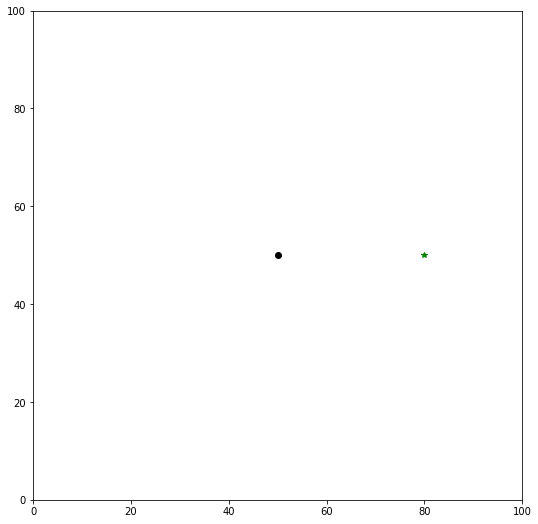

In [15]:
# define our visualization output & create it
VIS1 = VISUALIZATION(AUV1,ENV1)
VIS1.ShowReef()

Finally, we are able to call the path planner method `.PlanPath` with an argument that specifies the algorithm we want it to use (`alg=Dijkstra`), the environment we want to do the path planning for (`env=ENV1`), the visualization parameter (`vis=None`), and the risk parameter, which defines how much we care about risk, (`alpha=0`). Then we just let the vehicle explore on its path, save the visualization of the exploration to the visualization object's attribute `.video`, and display it as an HTML:

In [16]:
# Plan the path and animate the search process
anim = AUV1.PlanPath(alg = "Dijkstra", cost=cost_no_current_no_risk, heuristic=None, env = ENV1, vis=VIS1, alpha=0)
HTML(VIS1.searchAnimation.to_html5_video())

Generated Cost map...
Completed!
Searching for path to goal...
Goal found!
Preparing visualization...
Complete!


KeyboardInterrupt: 

Note that Dijkstra's algorithm searches uniformly throughout the environment until the goal is found. This is inefficient as many nodes need to be explored, even if they are not in the direction of the goal.

Let's see if things improve with the A* algorithm by repeating the above steps, this time setting `alg=A*`, and providing our heuristic function to guide the search.

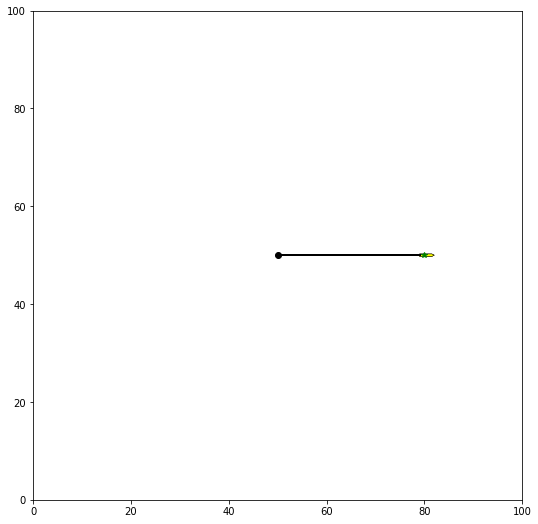

In [17]:
# need to reinstantiate the visualization class to get animations to show in notebook ...
VIS1 = VISUALIZATION(AUV1,ENV1)
VIS1.ShowReef()

# plan path for the pool test environment
AUV1.PlanPath(alg = "A*", cost = cost_no_current_no_risk, heuristic = heuristic_no_current_no_risk, env = ENV1, vis=None, alpha=0)
VIS1.video = VIS1.Explore()
HTML(VIS1.video.to_html5_video())

Take a moment to appreciate the difference in the exploration of the search space between A\* and Dijkstra. The A* planner uses its heuristic to quickly search in the direction of the goal. Because only a few nodes are explored, fewer calculations are needed and the runtime is relatively short. Note however, that both algorithms will ultimately find the same path.

# 3.0 Modeling the AUV mission
With the path-planning algorithms tested in the swimming pool, the group is now confident to take on the challenge of the more realistic mission environment. The ORI provides the MERS group with a map of the mission site which shows the size of the allowable mission region and the depth of the reef at the mission site. For this mission, the AUV will operate at a constant depth of $9.5\text{m}$. The figure below shows the mission environment.

In [18]:
plt.rcParams['figure.figsize'] = [size+2, size+2]
InspectReefData3D()

KeyboardInterrupt: 

### 3.1 Modeling obstacles and risk in the environment
Clearly, at a depth of 9.5m the path planner will have to account for obstacles. We encode obstacles by assigning the maximum risk value of $1$ to every node in the obstacle's area. The risk corresponds to the product of probability and severity of hazards to the mission at each point. While nodes inside an obstacle are assigned the maximum risk value of $1$, collision-free nodes are assigned a risk of $0$. 

To visualize the obstacles we create a new environment using a reef function built from the ORI data. We can then visualize the mission environment as before, using a contour plot to show the depth, and highlight the high risk obstacle nodes in red.

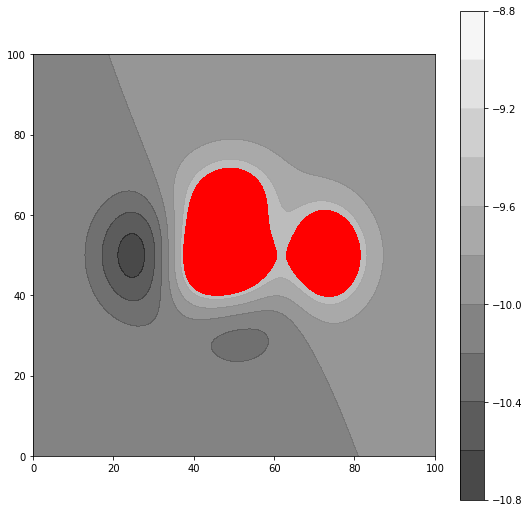

In [14]:
plt.rcParams['figure.figsize'] = [size, size]

ENV2 = ENVIRONMENT(UEXP, ReefFunction='reef')
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)

In addition to the obstacles, the ORI has also warned the group that there are some areas that might contain hazards due to geothermal activity, and that these areas should be avoided if possible. 

We encode these areas as additional risk regions in the environment. Each region is a polygon, defined by corner points. We provide the information on the corner points to the environment object `ENV2` by passing a dictionary of corner coordinates keyed by each region's risk value via the `.UnknownRegions` attribute. A risk of 1 corresponds to certain mission failure and is treated just like an obstacle, whereas lower risk values are less likely to fail the mission. Please see the visualization of the risk regions together with the environment (including obstacles) below:

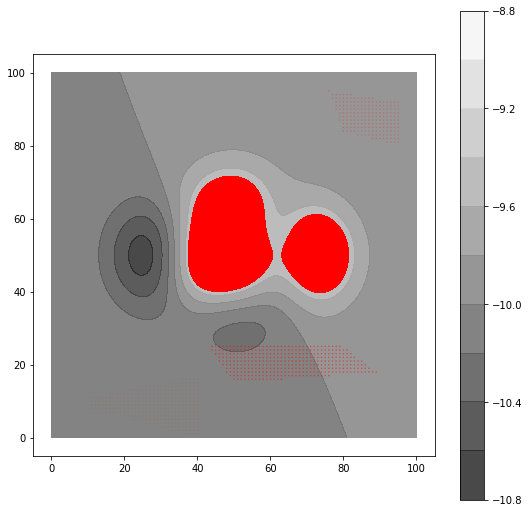

In [15]:
plt.rcParams['figure.figsize'] = [size, size]

ENV2 = ENVIRONMENT(UEXP, ReefFunction=None)

ENV2.UnknownRegions = { \
                       0.8: [(50, 15), (43, 25), (80, 25), (88, 19), (90,18)], \
                       0.4: [(80, 84), (95, 80), (95, 92), (76, 95)], \
                       0.1: [(11, 8), (40, 0), (40, 17), (11, 11)] \
                       }
ENV2.RiskField = ENV2.GenerateRiskField()

VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)
VIS2.ShowRisk()
plt.show()

### 3.2 Accounting for risk in the cost function
Although we now have a way to model risk we still need to incorporate risk into our path planning heuristic, which currently only depends on the time, $T$, required to reach the goal. Since the risk $R$ at each point has a value between 0 and 1, we wish to scale our cost by a function of $R$. To do this, we first introduce a risk aversion parameter, $\alpha\in [0,1]$, which governs how much we care about risk. A value of $\alpha=0$ means we ignore risk entirely, while $\alpha=1$ is completely risk averse, placing high importance on avoiding risk. The equation we use for our new cost function is below:

$$H=T\bigg(\frac{1}{1 - \alpha R + \epsilon}\bigg)$$

The higher the risk, the higher the heuristic cost. Here $\epsilon$ is a very small number included to avoid division by 0.


<div class="alert alert-info">
In the cell below, we want to redefine our cost function to one that incorporates risk. Note that `node.risk` will return the risk value (a scalar) at a given node. Now go ahead and redefine the cost function. Please make sure your output matches the type specification below (same as before as we just extend our cost function for more functionality). Use an epsilon of 1e-10:
</div>

- Output of the function as `tuple`:
- first part of tuple is cost as `float`
- second part of tuple is AUV veloctiy as `numpy.ndarray`

In [7]:
def costwithrisk(node1, node2, AUVspeed, alpha):
    ### BEGIN SOLUTION
    timetodestination = dist(node1,node2)/AUVspeed
    riskfactor = (1/(1-alpha*node2.risk + 1e-10))
    
    s = computeunitvector(node1,node2)
    V_AUV = s*AUVspeed
    
    return riskfactor*timetodestination, V_AUV
    ### END SOLUTION

In [8]:
test_costwithrisk(costwithrisk)

Tests passed!!

<div class="alert alert-info">
Now that the cost function has been extended we also need our heuristic to incorporate risk. Use the previously introduced heuristic and redefine it to also incorporate risk in the cell below. Please make sure your output matches the type specification below (same as before as we just extend our heuristic for more functionality):
</div>

- Output of the function as `float`

In [9]:
def heuristicwithrisk(node1, node2, AUVspeed):
    ### BEGIN SOLUTION
    timetodestination = dist(node1,node2)/AUVspeed
    return timetodestination 
    ### END SOLUTION

In [10]:
test_heuristicwithrisk(heuristicwithrisk)

Tests passed!!

### 3.3 Planning with risk
As all the preparation is done and we now have both, a cost function and a heuristic that incorporate risk, we can test our path planners using the new heuristic. We will send out our AUV on its first mission into the reef early in the morning, when the currents are calm enough to ignore.

<div class="alert alert-info">
Use the cell below the answer box to experiment with both A* and Dijkstras method, different values of alpha, and different origin and goal locations. Does the path-planner behave as you expect?
</div>

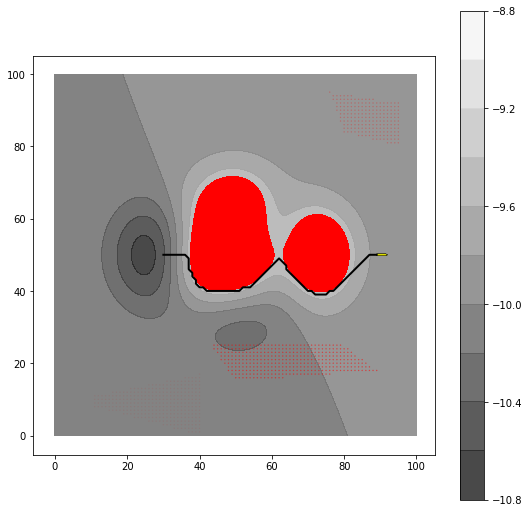

In [20]:
# define our visualization output & create it
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)
VIS2.ShowRisk()

AUV1.origin = (30, 50, -9.5)
AUV1.goal = (90, 50,-9.5)

AUV1.PlanPath(alg = "A*", cost = costwithrisk, heuristic = heuristicwithrisk, env = ENV2, vis=None,  alpha=1)
VIS2.video = VIS2.Explore()
HTML(VIS2.video.to_html5_video())

### 3.4 Adding uncertainty to the risk
You may notice that even when the risk aversion, $\alpha$, is set to 1, the AUV still travels very close to obstacles. So far our environment model assumes the risk regions and obstacle locations we are given are accurate. However, if the location of an obstacle in our risk map is imperfect, then having our AUV travel close to the predicted obstacle location could be catastrophic. Furthermore, a path that travels so close to obstacles will require a perfect path following algorithm. Any imprecision in the AUV's ability to follow this path could result in a mission failure.

In order to be safe and prevent losing their very expensive AUV, a member of the team comes up with the idea of blurring the risk around obstacles and unknown regions. This will have the effect of adding uncertainty to our risk field, making regions near obstacles more risky. 

<div class="alert alert-info">
Now implement a function that takes the variables `RiskField` and `sigma` and applies a Gaussian blur to it. `RiskField` is a 2D array of risk values, where each entry corresponds to a node (position) in the environment. The parameter `sigma` corresponds to the standard deviation of the Gaussian used for blurring and defines the degree to which the risk field is blurred (higher sigma means more blur). Your function should return the blurred risk field as a 2-D array. Please make sure your output matches the type specification below:
</div> 

- Output of the function: blurred risk field as `numpy.ndarray`

In [11]:
def blurRiskField(RiskField, sigma):
    """
    > RiskField is a 2D array of values r_ij = r(x_j, y_i)
    > sigma is the Gaussian standard deviation in meters (in the field)
    """
    ### BEGIN SOLUTION
    G = scipy.ndimage.gaussian_filter(RiskField, sigma, mode='reflect', cval=0.0, truncate=4.0)
    return G
    ### END SOLUTION

In [12]:
test_blurRiskField(blurRiskField)

Tests passed!!

Now experiment with different values of sigma to see the effect of this parameter in the code cell below. Then go ahead and answer the short answer questions below. 

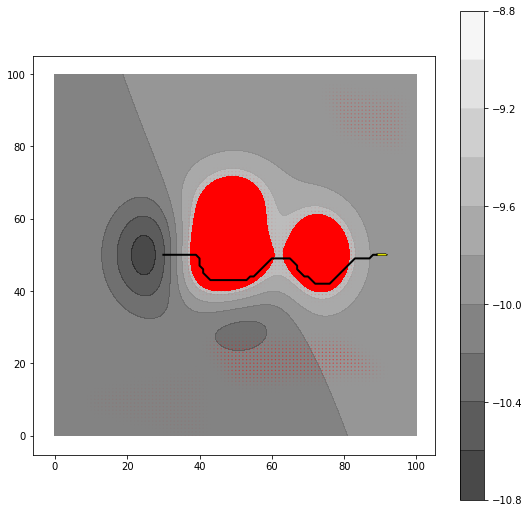

In [23]:
ENV2 = ENVIRONMENT(UEXP, ReefFunction=None)

ENV2.UnknownRegions = { \
                       0.8: [(50, 15), (43, 25), (80, 25), (88, 19), (90,18)], \
                       0.4: [(80, 84), (95, 80), (95, 92), (76, 95)], \
                       0.1: [(11, 8), (40, 0), (40, 17), (11, 11)] \
                       }
ENV2.RiskField = ENV2.GenerateRiskField()

sigma = 1.5
ENV2.RiskField = blurRiskField(ENV2.RiskField, sigma)
# define our visualization output & create it
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)
VIS2.ShowRisk()

AUV1.origin = (30, 50, -9.5)
AUV1.goal = (90, 50,-9.5)

AUV1.PlanPath(alg = "A*", cost = costwithrisk, heuristic = heuristicwithrisk, env = ENV2, vis=None,  alpha=1)
VIS2.video = VIS2.Explore()
HTML(VIS2.video.to_html5_video())

## Short Answer Questions
<div class="alert alert-info">
Does the risk blurring (as we have implemented it) achieve the desired effect (optimal path changes so that AUV stays further away from the obstacles)? If not, how could it be improved?
</div> 

At the moment, no - the risk blurring increases the risk values in the surrounding area, but also decreases the risk values of the areas near the edges within the obstacles. We could improve this by, for each point, taking the max of the original risk value and the newly calculated blurred risk value. That way, we never decrease a risk value (never say an area is safer than what we originally thought).

<div class="alert alert-info">
How would you select the sigma parameter for a real mission? Which factors would you take into consideration?
</div> 

The sigma parameter will depend heavily on observations of the environment. Factors include current patterns, measurement and environmental uncertainty, and the ability for the AUV to track the planned path.

# 4.0 A Damsel in Distress
Right before finishing their mission and pulling the AUV back onto the boat a person from a superyacht nearby desperately begs for help: Enjoying the sun on the roof deck of her ship the diamond on her ring fell off and into the water. She is very upset to find it and as the MERS group happens to be in the area they offer their support in finding the diamond. 

This is a risky undertaking as the MERS group knows that their AUV battery is running low, and at this late time of the day, the currents will probably have built up to where they can no longer be ignored. In order for the AUV to navigate back to the boat, the planning will not only have to take into account obstacles and risky regions but also the strong underwater currents.
![](mission3.png) <br>

### 4.1 Modeling ocean currents

Currents are moving masses of water with a certain direction and speed. Therefore, in general, currents can be represented by vectors. The vector's length represents the speed of the current while its direction models the direction of the current. Hence, to model the currents in our mission region we assign a vector to each point in our 2-D grid.

In the scope of this problem set you will be able to look at three different types of currents that are stored in the backbone of the `ENVIRONMENT` class (see figure below). You will only have to deal with the _circular current_ as part of your exercise. However, you are free to experiment with all of the current types (uniform in x, uniform in y, and circular).

<table><tr><td><div style="width:image width px; font-size:100%; text-align:center;"><img src='current_uniformx.png' />Uniform current in x-direction.</div></td><td<div style="width:image width px; font-size:100%; text-align:center;"><img src='current_uniformy.png' />Uniform current in y-direction.</div></td><td><div style="width:image width px; font-size:100%; text-align:center;"><img src='current_circular.png' />Circular current.</div></td></tr></table>

In order to bring in currents into your model of the environment you will only have to set the current attribute `CurrentField` of your environment class instance `ENV2`. You can generate a current field by using the `ENVIRONMENT` class method `GenerateCurrentField` and providing one of the key words `"whirlpool"`, `"uniform_x"`, or `"uniform_y"` to the `type` argument of the method and specifying the maximum strength of the current by providing `max_strength = ...`. Following these steps we can include a 2-D current vector field in our mission environment model. Please see the visualization of our updated environmental model by executing the following cell. 

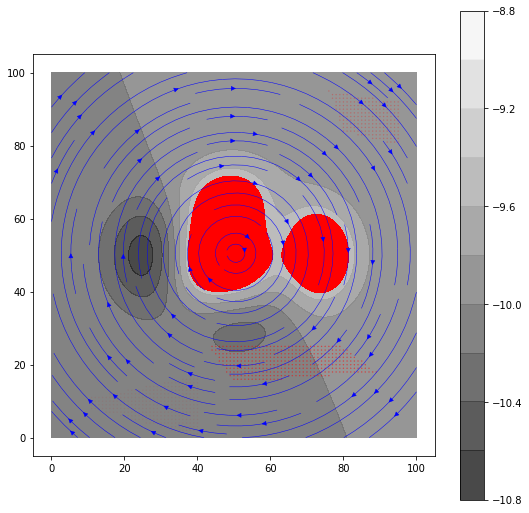

In [24]:
ENV2 = ENVIRONMENT(UEXP, ReefFunction=None)

ENV2.UnknownRegions = { \
                       0.8: [(50, 15), (43, 25), (80, 25), (88, 19), (90,18)], \
                       0.4: [(80, 84), (95, 80), (95, 92), (76, 95)], \
                       0.1: [(11, 8), (40, 0), (40, 17), (11, 11)] \
                       }
ENV2.RiskField = ENV2.GenerateRiskField()
ENV2.CurrentField_x, ENV2.CurrentField_y =  ENV2.GenerateCurrentField(type="whirlpool", max_strength=1)
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)
VIS2.ShowRisk()
VIS2.ShowCurrent()

### 4.2 Incorporating currents in the path planner

Just like we did above for risk after introducing currents into our model we also have to incorporate the current into the cost function of our algorithm and the heuristic. So far our cost, the traversal time, was a function of the AUV's speed only. Therefore, we want to modify our time cost $T$ to include the effect of the local currents. 

In order to come up with a cost function let's take a look at a generic node and its neighbor. Given the maximum speed of our AUV $||v_{AUV}||$, the current vector at the neighboring node $v_{current}$, the distance $d$ between the two nodes, and the unit vector $\hat{s}$ indicating the direction towards the goal, we can calculate:

$$T = \frac{d}{||v_{AUV}||+v_{current}\cdot\hat{s}}$$ 

The denominator gives us the combined speed that results from adding the perpendicular of $v_{current}$ to the AUV's base speed, so the overall equation provides us with the time cost of reaching the neighboring node in terms of how much closer it will bring us in the direction of our goal.

<div class="alert alert-info">
Now implement the above updated cost function in the cell below so that it returns the cost (traversal time) between the two nodes, as well as a 2D vector, V_AUV, which defines the velocity of the AUV as it leaves the current node heading to the next one. Please make sure your output matches the type specification below:
</div> 

- Output of the function as `tuple`:
- first part of tuple is cost as `float`
- second part of tuple is AUV veloctiy as `numpy.ndarray`

In [13]:
def costwithcurrents(node1, node2, AUVspeed, alpha):
    ### BEGIN SOLUTION
    S = AUVspeed
    #Use the current at the first node (could also use the average between node1 and node2)"
    V_current = node1.current

    #Unit vector from node1 to node2: use only x,y components
    s = np.array(node2.position)-np.array(node1.position)
    s = s[0:2].flatten()
    ns = np.linalg.norm(s)
    if ns < 1e-10:
        return (0.0, np.array((0.0,0.0)))
    s = s/ns


    c = -(V_current[0]*s[1]-V_current[1]*s[0])

    # Compute V_AUV - the required AUV velocity direction to get us from node1 to node2, accounting for the current
    # uses quadratic formula, so have to check if we want the negative or positive solution
    V_AUVy = (np.sqrt((s[0]**2)*(s[1]**2)*(S**2)+ (s[1]**4)*(S**2) -(s[1]**2)*c**2) -s[0]*c)

    V_AUVpp = np.array((np.sqrt(S**2 - V_AUVy**2),V_AUVy))
    V_AUVpn = np.array((np.sqrt(S**2 - V_AUVy**2),-V_AUVy))
    V_AUVnp = np.array((-np.sqrt(S**2 - V_AUVy**2),V_AUVy))
    V_AUVnn = np.array((-np.sqrt(S**2 - V_AUVy**2),-V_AUVy))

    list = [V_AUVpp,V_AUVpn, V_AUVnp,V_AUVnn]

    V_AUV = list[np.argmax([np.dot(V+V_current,s) for V in list])]

    # compute the speed we are travelling in the target direction, i.e. from node1 to node2
    SpeedInTargetDirection = np.dot(V_AUV,s) + np.dot(V_current,s)

    # compute the time it will take to travel from node1 to node2 - handle edge case that 0 speed=inf time
    time = dist(node1,node2)/SpeedInTargetDirection if SpeedInTargetDirection != 0 else 0
    timeToDestination = (time if time > 0  else np.inf)
    
    riskfactor = (1/(1-alpha*node2.risk + 1e-10))
    
    return float(riskfactor*timeToDestination), V_AUV
    ### END SOLUTION

In [14]:
test_costwithcurrents(costwithcurrents)

Tests passed!!

Just like at the beginning, for A* we also need to implement a function that computes the cost-to-go from a given node. 
<div class="alert alert-info">
Please go ahead and implement an updated version of the heuristic that also takes into account currents in the cell below. Your function should take two nodes (`node1` and `node2`) as well as the AUV's speed (AUVspeed) as an input and return the estimated time to the destination. Please make sure your output matches the type specification below:
</div> 

- Output of the function: estimated time to destination as `float`

In [3]:
def heuristicwithcurrents(node1, node2, AUVspeed, max_strength=1):
    ### BEGIN SOLUTION
    timetodestination = dist(node1,node2)/(AUVspeed + max_strength)
    return timetodestination 
    ### END SOLUTION

In [4]:
from unittests import test_heuristicwithcurrents
test_heuristicwithcurrents(heuristicwithcurrents)

Tests passed!!

### 4.3 Executing the mission

Now as we have a cost function that takes into account obstacles and risk as well as currents we can send the AUV out into the reef and test how well it navigates through the stronger currents. Go ahead, execute the cell below, and carefully observe the AUV's movement on its exploration mission. 

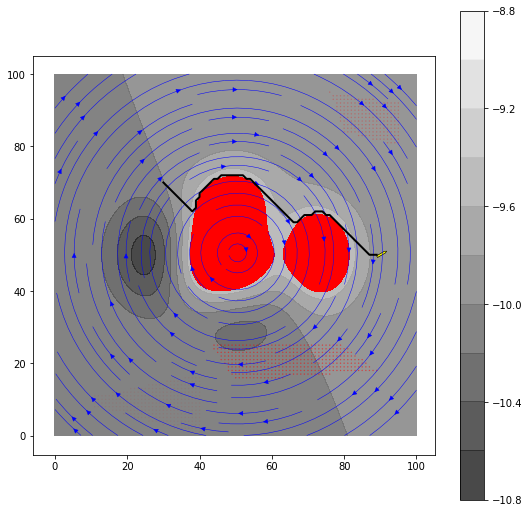

In [29]:
ENV2 = ENVIRONMENT(UEXP, ReefFunction=None)

ENV2.UnknownRegions = { \
                       0.8: [(50, 15), (43, 25), (80, 25), (88, 19), (90,18)], \
                       0.4: [(80, 84), (95, 80), (95, 92), (76, 95)], \
                       0.1: [(11, 8), (40, 0), (40, 17), (11, 11)] \
                       }
ENV2.RiskField = ENV2.GenerateRiskField()
ENV2.CurrentField_x, ENV2.CurrentField_y =  ENV2.GenerateCurrentField(type="whirlpool", max_strength=1)
VIS2 = VISUALIZATION(AUV1,ENV2)
VIS2.ShowReef()
VIS2.ShowObstacles(-9.5)
VIS2.ShowRisk()
VIS2.ShowCurrent()


AUV1.origin = (30, 70, -9.5)
AUV1.goal = (90, 50,-9.5)

AUV1.PlanPath(alg = "A*", cost = costwithcurrents, heuristic = heuristicwithcurrents, env = ENV2, vis=None,  alpha=1)
VIS2.video = VIS2.Explore()
HTML(VIS2.video.to_html5_video())

# 5.0 Algorithmic Limitations and Extensions

In this section we want you to reflect on your observations during this tutorial/problem set and think about the limitations of the algorithms that we used. More specifically, we want you to compare a subset of the possible algorithmic extensions you've seen in class (we only refer to our Energy-Efficient Path Planning in Uncertain Environments lecture) and evaluate their suitability for the given problem.

**Any-angle methods** <br>
<div class="alert alert-info">
What might be advantages of applying an any-angle algorithm (such as Theta*) to this problem? What might be a disadvantage? (Hint: Think about the effect of current field on the path planning!) 
</div> 

Advantages: An angle-angle algorithm will give us shorter (and therefore more efficient) paths. These paths will also have more realistic angles for the AUV to move in (opposed to sharp angles, which may be impossible to follow due to physical constraints)

Disadvantage: The current field vector at the point used for linear extrapolation may be very different (in both speed and direction) from the current field vectors in the immediate local area, especially if the extrapolation point is far away. This may result in a misleading estimate of the cost to go.

**Post-smoothing** <br>
<div class="alert alert-info">
In class we discussed the idea of smoothing the path returned by a non angle-angle algorithm, such as A*. Are there any cases where you could imagine that we might run into issues with such post-smoothing? 
</div> 

Suppose you have a very angular obstacle, such as a large rock in the shape of a square. A path produced by A* may follow the edges of the obstacle very closely. Smoothing this path may result in the new path cutting into the obstacle, resulting in a collision.

Additionally, issues may also occur if the current varies wildly within short distances. The original path produced by A* may follow currents that aim the AUV towards the goal, but a smoothed path may potentially push the AUV into an area where the currents all point in the opposite direction.

**D\*/D\* Lite** <br>
<div class="alert alert-info">
What is the benefit of using a D* approach to this problem? Can you think of any case where this might backfire? If so, how might we solve this problem? (Hint: Think about sensor noise!)
</div> 

As discussed in lecture, when working in an uncertain environment we may have to deal with inaccurate information about hazards in the environment and run into new obstacles when following a plan. A D* approach will therefore allow us to efficiently replan parts of the path around these obstacles. However, one case when this may backfire is if our sensors pick up some noise and interprets it as an obstacle that may not actually exist. Then our AUV will waste time computing a new and possibly longer path around the imaginary obstacle. This could be resolved by introducing a probablistic approach (such as using hidden Markov models) to decide whether or not there is a new obstacle.

**Further limitations** <br>
<div class="alert alert-info">
Can you think of another limitation(s) to the algorithm that we **did not** discuss in the lecture? How could you go about changing or modifying the approach to address this limitation?
</div> 

Example 1: Calculating risk values for new obstacles (can use neural nets for classification)

Example 2: Predicting currents (machine learning with how waves move around different obstacle shapes)

Example 3: Physical constraints on the AUV (modify the algorithm to include limits on angles, etc)